# Metadata annotation

This notebook demonstrates how to use pertpy to develop and evaluate models for perturbation response prediction using publicly available metadata.

Advancements in multiplexed single-cell transcriptomics across experiments have revolutionized the high-throughput study of drug and genetic perturbations, enabling the measurement of hundreds of thousands of cells under unique conditions. Traditionally, institutes established comprehensive databases to understand these perturbation mechanisms on a large scale. Recently, machine learning techniques have inspired the development of computational methods in modeling single-cell perturbation responses. To enhance the computational and statistical power of these approaches, we can integrate the data collected in the databases to develop, train, and test such models.

For this purpose, pertpy provides tooling to allow more metadata to be easily fetched and perturbations to be annotated. This can help augment existing datasets with more datasets to increase sample sizes for training of machine learning models and add prior knowledge of data that cannot be seen initially. 

In pertpy, access to metadata databases is facilitated through `MetaData` objects that directly access the data bases through either the databases API or by caching their knowledge on-disk. Alongside the `MetaData` object, a `lookup` class is provided, enabling database queries before annotation:
- `lookup.available_{metadata}`: Given a list of unique query IDs (e.g. cell line identifiers in the `adata.obs`) for the cells, the number of matched and not-matched identifiers in the metadata is returned.
- `lookup.{metadata}.default_parameter`: Document default parameters of each annotating functions in the docstrings.


In [1]:
import random
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

Let's load the dataset from the original MIX-Seq paper ([McFarland et al., 2020](https://www.nature.com/articles/s41467-020-17440-w)). It is a scRNA-seq dataset which profiles the response of 182875 cells across pools of up to 99 cell lines to a range of 13 different drugs, as well as to CRISPR perturbations. We subset it to 50000 cells to speed up the run time.

In [2]:
adata = pt.dt.mcfarland_2020()
sc.pp.subsample(adata, n_obs = 50000, random_state=42)

## Cell line metadata

A cell line refers to a group of immortalized cells. Cell line metadata usually contains clinical and biospecimen data of cell lines, offering insights into the biological variance across different cell lines. To facilitate the annotation of cell line metadata, a couple of databases can be queried, which can be categorized by the type of metadata:
- Cell line metadata： 
    - Cancer Dependency Map (DepMap) at Broad
    - Genomics of Drug Sensitivity in Cancer (GDSC)
- Genomic datasets:
    - DepMap at Broad: Gene expression data
    - DepMap at Sanger: Gene expression and protein intensity values
- Cell line x perturbation interactions:
    - Genomics of Drug Sensitivity in Cancer (GDSC): Drug sensitivity

The pertpy `CellLineMetaData` object is used to annotate cell line metadata specifically. The `annotate_cell_lines` function facilitates this process by using DepMap IDs as identifiers and annotating metadata as new columns in the `obs` by default.

In [3]:
pt_metadata = pt.tl.CellLineMetaData()
pt_metadata.annotate_cell_lines(adata)
# Annotated metadata is saved as additional columns in adata.obs
adata.obs.iloc[:, 36:]

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,primary_or_metastasis,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
TTATGCTAGTGATCGG,NCI-H1581,NCIH1581,NCIH1581_LUNG,NCI-H2077,908471.0,ATCC,CVCL_1479,1237.0,lung,Primary,...,NSCLC_large_cell,NaN,2D: mixed adherent and suspension,NaN,NaN,PT-ffwajI,NaN,Lung large cell carcinoma,C4450,NaN
AGCGTCGTCTCGGACG,SNU-1105,SNU1105,SNU1105_CENTRAL_NERVOUS_SYSTEM,NaN,NaN,KCLB,CVCL_5010,NaN,central_nervous_system,Primary,...,glioblastoma,NaN,NaN,NaN,NaN,PT-U0kXHW,NaN,Glioblastoma,C3058,NaN
TTGGGTACATTGCTTT,SK-MEL-3,SKMEL3,SKMEL3_SKIN,NaN,909724.0,ATCC,CVCL_0550,1572.0,lymph_node,Metastasis,...,NaN,NaN,2D: adherent,NaN,NaN,PT-TEoeSm,NaN,Cutaneous melanoma,C3510,NaN
TACTTGTTCAGCGACC,786-O,786O,786O_KIDNEY,NaN,905947.0,ATCC,CVCL_1051,301.0,kidney,Primary,...,clear_cell,NaN,2D: adherent,NaN,NaN,PT-4QH2lI,NaN,Renal cell carcinoma,C9385,NaN
CACAGTATCGGCTACG,COLO-680N,COLO680N,COLO680N_OESOPHAGUS,NaN,906817.0,DSMZ,CVCL_1131,1469.0,oesophagus,NaN,...,NaN,NaN,2D: adherent,NaN,NaN,PT-es34jp,NaN,Esophageal squamous cell carcinoma,C4024,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGCCCTACATGAGCGA,KYSE-270,KYSE270,KYSE270_OESOPHAGUS,NaN,907319.0,DSMZ,CVCL_1350,1518.0,oesophagus,Primary,...,NaN,NaN,2D: adherent,NaN,NaN,PT-8iaWjG,NaN,Esophageal squamous cell carcinoma,C4024,NaN
CTGATCCGTATGTCAC,BT-474,BT474,BT474_BREAST,NaN,946359.0,ATCC,CVCL_0179,412.0,breast,Primary,...,ERpos_HER2pos,HER2_amp,2D: adherent,NaN,NaN,PT-Az6j9u,NaN,Invasive breast carcinoma of no special type,C4194,NaN
TATTACCAGCAGACTG,NCI-H460,NCIH460,NCIH460_LUNG,NaN,905943.0,ATCC,CVCL_0459,2146.0,pleural_effusion,Metastasis,...,NSCLC_large_cell,NaN,2D: adherent,NaN,NaN,PT-gfHIRD,NaN,Lung large cell carcinoma,C4450,NaN
TGTGGTATCTCCAGGG,SK-MEL-3,SKMEL3,SKMEL3_SKIN,NaN,909724.0,ATCC,CVCL_0550,1572.0,lymph_node,Metastasis,...,NaN,NaN,2D: adherent,NaN,NaN,PT-TEoeSm,NaN,Cutaneous melanoma,C3510,NaN


Here we choose to annotate bulk RNA expression data from the Broad Institute because it contains more overlapping cell lines with the McFarland dataset. The number of matched identifiers in bulk RNA-seq data sourced from Sanger Institute can be checked via `lookup.available_bulk_rna_expression(query_id_list=adata.obs.cell_line.unique())`.

In [4]:
lookup = pt_metadata.lookup()
lookup.available_bulk_rna_expression(query_id_list=adata.obs.DepMap_ID.unique(), cell_line_source='broad')

1 cell lines are not found in the metadata.

208 cell lines are found!

Note that cell line name is used as reference ID when annotating bulk RNA expression from Sanger, whereas DepMap ID is used for bulk RNA expression data from Broad. Further parameters can be checked using `look.up.bulk_rna.{cell_line_source}.default_parameter` where `cell_line_source` should be either broad or sanger.

In [5]:
pt_metadata.annotate_bulk_rna_expression(adata, cell_line_source="broad", query_id = "DepMap_ID")

To annotate bulk RNA expression data from Broad Institue,  `DepMap_ID` is used as default reference and query 
indentifier if no `reference_id` is given.  Please make sure that `DepMap_ID` is available in the adata.obs.  
Alternatively, use the `annotate_cell_lines()` function to annotate the cell line first

There are 209 identifiers in `adata.obs`.

Following 1 identifiers can't be found in bulk RNA expression data, 

leading to the presence of NA values for their respective metadata. Please check again: 
- ACH-000047

AnnData object with n_obs × n_vars = 50000 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'patient_

The fetched bulk RNA expression data sourced from Broad institue is stored as a dataframe within `adata.obsm[bulk_rna_expression_broad]`

In [6]:
adata.obsm['bulk_rna_expression_broad']

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
TTATGCTAGTGATCGG,4.179511,0.0,6.990161,2.950468,3.697107,0.014355,3.548437,6.184875,4.370164,4.319762,...,0.056584,0.263034,0.263034,0.014355,0.028569,0.545968,4.220330,0.000000,0.0,0.000000
AGCGTCGTCTCGGACG,3.681449,0.0,5.923149,2.039138,3.928844,0.163499,4.111866,7.195840,4.196922,4.144862,...,0.111031,0.000000,0.042644,0.000000,0.189034,0.516015,4.757557,0.000000,0.0,0.070389
TTGGGTACATTGCTTT,3.705978,0.0,7.598425,2.350497,4.340562,0.014355,3.849999,5.710944,3.939227,4.294253,...,0.028569,0.495695,0.000000,0.150560,0.097611,0.333424,4.938286,0.000000,0.0,0.000000
TACTTGTTCAGCGACC,2.448901,0.0,7.185966,1.879706,4.455492,0.000000,3.160275,6.842476,4.191405,3.580145,...,0.000000,0.000000,0.000000,0.014355,0.124328,0.333424,4.521051,0.000000,0.0,0.000000
CACAGTATCGGCTACG,5.297558,0.0,6.513175,2.533563,3.054848,0.111031,2.565597,6.452859,4.785027,4.081510,...,0.028569,0.000000,0.389567,0.014355,0.238787,1.709291,2.805292,0.333424,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGCCCTACATGAGCGA,4.510329,0.0,6.109778,1.599318,3.217231,0.042644,1.163499,5.084915,4.130931,3.440952,...,0.000000,0.000000,0.000000,0.000000,0.238787,0.250962,4.322649,0.000000,0.0,0.000000
CTGATCCGTATGTCAC,2.238787,0.0,7.446174,4.002703,4.600508,0.000000,0.042644,4.047015,4.863443,4.289097,...,0.000000,0.000000,0.000000,0.000000,0.124328,0.565597,3.145677,0.070389,0.0,0.000000
TATTACCAGCAGACTG,3.995485,0.0,6.461398,2.017922,4.374344,0.028569,3.881665,5.597531,6.032982,3.571677,...,0.014355,0.000000,0.028569,0.028569,0.042644,0.411426,4.489286,0.137504,0.0,0.000000
TGTGGTATCTCCAGGG,3.705978,0.0,7.598425,2.350497,4.340562,0.014355,3.849999,5.710944,3.939227,4.294253,...,0.028569,0.495695,0.000000,0.150560,0.097611,0.333424,4.938286,0.000000,0.0,0.000000


Post-treatment differential expression data can offer valuable insights into understanding the relationship between gene expression and drug responses. To demonstrate how pertpy can be used to model perturbation responses, a linear regression model can be trained to associate the single-cell transcriptional profiles measured in each cell line to their viability effects in the drug sensitivity data from GDSC. 

However, it is important to do a quality check before training the model. This is because the McFarland dataset and annotated bulkRNA-seq data represent two entirely different datasets and we need to make sure the cell lines from different sources are indeed the same and can be compared properly. To achieve this, we generate "pseudobulks" by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [8]:
# Extract the baseline
adata.obs['DepMap_ID'] = adata.obs['DepMap_ID'].astype('category')
adata_control = adata[adata.obs.perturbation == 'control']
adata_control.obs.reset_index(drop=True, inplace=True)

# Calculate the mean gene expression of each cell line
base_line_expression = pd.DataFrame(columns=adata_control.var_names, index=adata_control.obs['DepMap_ID'].cat.categories)                                                                                                 
for cl in adata_control.obs.DepMap_ID.cat.categories: 
    base_line_expression.loc[cl] = adata_control[adata_control.obs['DepMap_ID'] == cl].X.mean(0)
base_line_expression.reset_index(inplace=True)
base_line_expression = pd.melt(base_line_expression, id_vars='index', var_name='Gene', value_name='Baseline')

# Merged with bulk RNA-seq data at Broad
broad_rna_gene = pt_metadata.bulk_rna_broad
broad_rna_gene.columns = [gene_name.split(' (')[0] for gene_name in broad_rna_gene.columns.values]
broad_rna_gene = broad_rna_gene.reset_index()
broad_rna_gene = pd.melt(broad_rna_gene, id_vars='index', var_name='Gene', value_name='Broad')

compare_cl_expr = base_line_expression.merge(broad_rna_gene, how = "inner")
compare_cl_expr.head()

,index,Gene,Baseline,Broad
0,ACH-000001,MIR1302-10,0.0,0.0
1,ACH-000012,MIR1302-10,0.0,0.0
2,ACH-000014,MIR1302-10,0.0,0.0
3,ACH-000015,MIR1302-10,0.0,0.0
4,ACH-000021,MIR1302-10,0.0,0.0


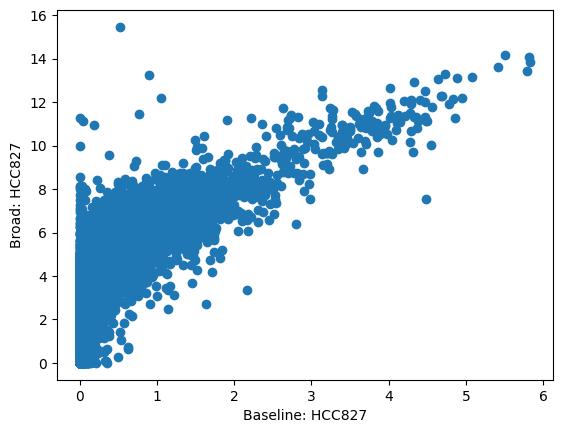

In [9]:
compare_cl_expr_subset = compare_cl_expr[compare_cl_expr['index']=="ACH-000012"] 
plt.scatter(x=compare_cl_expr_subset['Baseline'], y=compare_cl_expr_subset['Broad'])
plt.xlabel("Baseline: HCC827")
plt.ylabel("Broad: HCC827")
plt.show()

We observe a correlation between the baseline gene expression in the McFarland dataset and the bulk RNA-seq expression data from the Broad Institute, suggesting the use of the same cell lines. Cell line drug sensitivity data can then be retrieved from the GDSC database, which will be saved as a single column `ln_ic50` in `obs`.

In [10]:
pt_metadata.annotate_from_gdsc(adata)

Following 93 identifiers can not be found in the drug response data for GDSC1,leading to the presence of NA values 
for their respective metadata. Please check it again:
- UM-UC-1
- OAW42
- A-375
- KNS-60
- Malme-3M

AnnData object with n_obs × n_vars = 50000 × 32738
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments', 'lineage', 'lineage_subtype', 'lineage_sub_subtype', 'lineage_molecular_subtype', 'default_growth_pattern', 'model_manipulation', 'model_manipulation_details', 'patient_

In [11]:
adata.obs[['cell_line_name', 'ln_ic50']]

,cell_line_name,ln_ic50
index,,
TTATGCTAGTGATCGG,NCI-H1581,NaN
AGCGTCGTCTCGGACG,SNU-1105,NaN
TTGGGTACATTGCTTT,SK-MEL-3,-3.947646
TACTTGTTCAGCGACC,786-O,NaN
CACAGTATCGGCTACG,COLO-680N,NaN
...,...,...
TGCCCTACATGAGCGA,KYSE-270,4.379900
CTGATCCGTATGTCAC,BT-474,3.237311
TATTACCAGCAGACTG,NCI-H460,NaN


In [12]:
# subset the data where viability value is not missing values before performing linear regression.
viability = adata.obs.ln_ic50.values
not_na_viability = np.where(~np.isnan(viability))[0]
not_na_expr = adata.X.toarray()[not_na_viability]
not_na_viability = viability[not_na_viability]

In [13]:
# Split dataset into train and test data
train_num = int(len(not_na_viability) * 0.7)
train_index  = random.sample(range(len(not_na_viability)), train_num)
data_train = not_na_expr[train_index]
label_train = not_na_viability[train_index]

test_index = [idx for idx in range(len(not_na_viability)) if idx not in train_index] 
data_test = not_na_expr[test_index]
label_test = not_na_viability[test_index]

In [14]:
lr = LinearRegression()
lr.fit(data_train, label_train)
viability_predicted = lr.predict(data_test)

Mean squared error: 5.76
Coefficient of determination: 0.35


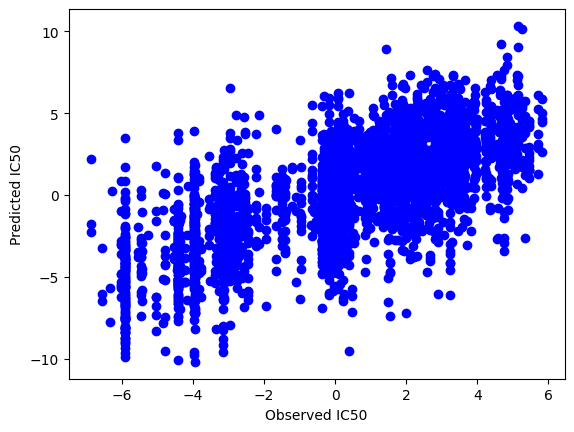

In [15]:
print(f"Mean squared error: {mean_squared_error(label_test, viability_predicted):.2f}")
print(f"Coefficient of determination: {r2_score(label_test, viability_predicted):.2f}")

plt.scatter(label_test, viability_predicted, color="blue")
plt.xlabel("Observed IC50")
plt.ylabel("Predicted IC50")
plt.show()

The model has a low coefficient of determination, indicating that the regression model doesn't fit the test data very well. This might be caused by the "noise" in drug response data collected under various experimental conditions. This makes it challenging for the model to fit the majority of observed data well. Feature selection might improve the model performance since the dataset contains the 32738 genes. However, there's still room for further analysis, such as comparing expression patterns of genes that have a high absolute value of coefficients across cell lines to assess their contribution to drug response. Considering that the McFarland dataset used experimental pools of up to 99 cell lines, we group the cell lines with similar drug response across different perturbation conditions. This is achieved by clustering them based on the drug-cell line matrix of IC50 values from GDSC. 

In [16]:
# Drug sensitivity data from GDSC database can be accessed by `metadata.drug_response_gdsc{1/2}` 
drug_response = pt_metadata.drug_response_gdsc1[pt_metadata.drug_response_gdsc1['cell_line_name'].isin(adata.obs.cell_line_name)]
drug_response = drug_response.pivot(index='cell_line_name', columns='drug_name', values='ln_ic50')
drug_response

drug_name,(5Z)-7-Oxozeaenol,5-Fluorouracil,965-D2,993-D2,A-443654,A-770041,A-83-01,ACY-1215,AGI-6780,AICA Ribonucleotide,...,ZG-10,ZL049,ZL109,ZM447439,ZSTK474,Zibotentan,"eEF2K Inhibitor, A-484954",kb NB 142-70,rTRAIL,torin2
cell_line_name,,,,,,,,,,,,,,,,,,,,,
42-MG-BA,0.588826,2.220896,2.992956,4.755989,NaN,NaN,3.793761,2.390197,1.303087,7.562482,...,NaN,2.995327,-0.980930,1.339098,2.235509,5.494359,5.566457,3.082294,-1.651262,NaN
5637,1.626606,3.166983,4.410360,4.227483,NaN,NaN,3.847780,1.039981,1.127383,8.011505,...,NaN,2.053874,0.046212,0.556022,0.239659,5.144572,5.273391,2.519340,-2.889220,NaN
639-V,0.785227,4.210295,2.932099,4.028036,NaN,NaN,4.628202,2.099868,1.479390,7.448695,...,1.453090,4.385755,0.039382,1.779944,2.425340,5.144169,5.143294,1.978599,-2.467352,NaN
647-V,0.570678,3.228626,2.930507,3.106849,NaN,NaN,4.581358,1.754079,1.670076,7.547167,...,NaN,3.188942,-1.045608,3.044114,0.603523,5.756456,5.430844,2.733492,0.201503,NaN
769-P,0.612362,1.396611,3.010508,2.978909,NaN,NaN,3.855192,1.800764,1.943585,8.259149,...,NaN,3.162116,-0.425794,2.532378,-0.411142,5.441282,5.592060,1.830003,-0.026884,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TE-11,1.972644,4.283297,2.979829,3.598220,-2.093281,0.282573,4.005342,3.104331,1.730219,4.407174,...,NaN,3.992947,0.354113,0.406621,2.985028,5.396288,5.396288,3.860937,-0.753742,NaN
TE-6,5.312667,1.765484,5.250599,4.294427,-1.035718,2.397666,4.348313,0.522500,NaN,9.012906,...,NaN,3.040703,1.057910,3.795597,-0.236517,5.880011,5.693825,1.948988,0.353520,NaN
TE-8,-0.905723,2.297967,2.880687,3.359580,-1.749262,-1.274661,1.281641,0.520580,1.081485,6.899094,...,0.734422,2.860551,-0.444158,1.197542,1.441510,5.765258,5.138028,0.833960,0.221525,NaN


Before performing the clustering, we can impute the missing values in cell line sensitivity data with the mean IC50 value of this drug. Here we use `SimpleImputer` from sklearn package.

In [17]:
imputer = SimpleImputer(strategy='mean')
drug_response_imputed = imputer.fit_transform(drug_response.values)
drug_response_imputed

array([[ 0.588826  ,  2.220896  ,  2.992956  , ...,  3.082294  ,
        -1.651262  , -1.84439795],
       [ 1.626606  ,  3.166983  ,  4.41036   , ...,  2.51934   ,
        -2.88922   , -1.84439795],
       [ 0.785227  ,  4.210295  ,  2.932099  , ...,  1.978599  ,
        -2.467352  , -1.84439795],
       ...,
       [-0.905723  ,  2.297967  ,  2.880687  , ...,  0.83396   ,
         0.221525  , -1.84439795],
       [-0.182098  ,  2.916789  ,  2.907251  , ...,  1.384364  ,
        -0.046915  , -3.600791  ],
       [-2.328306  ,  3.911201  ,  1.454216  , ...,  3.015774  ,
        -0.115816  , -1.84439795]])

In [18]:
# Create an drug x cell line anndata for drug response
drug_response_imputed = pd.DataFrame(data = drug_response_imputed,  
                  index = drug_response.index,  
                  columns = drug_response.columns)
adata_drug_reponse = ad.AnnData(drug_response_imputed)

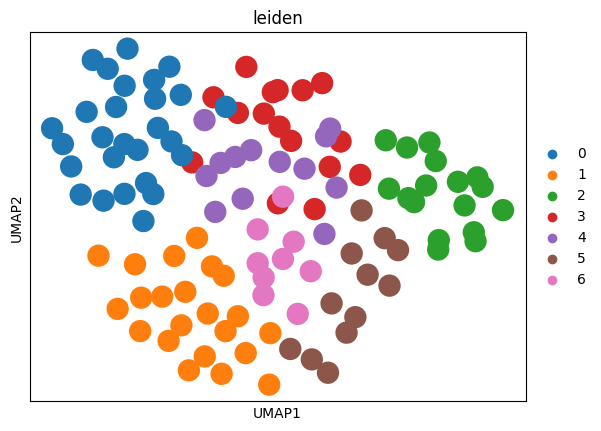

In [19]:
sc.pp.pca(adata_drug_reponse)
sc.pp.neighbors(adata_drug_reponse)
sc.tl.umap(adata_drug_reponse)
sc.tl.leiden(adata_drug_reponse, resolution = 1.5, key_added="leiden")
sc.pl.umap(adata_drug_reponse, color="leiden")

In [20]:
# Sort coefficients of the overlapping genes in decreasing order
coeffcient = {'coefficients': lr.coef_, 'genes': adata.var.index.values}
coeffcient = pd.DataFrame(coeffcient)
coeffcient= coeffcient.reindex(coeffcient['coefficients'].abs().sort_values(ascending=False).index)
coeffcient = coeffcient.reset_index(drop=True)
coeffcient

,coefficients,genes
0,0.243096,HIST1H1D
1,0.210806,MGAT4A
2,-0.203428,RPS15
3,-0.197674,TTBK2
4,0.197002,RAB40C
...,...,...
32733,0.000000,RP11-449L23.2
32734,0.000000,RP11-472G23.10
32735,0.000000,RP11-115E19.1
32736,0.000000,RP11-882G5.1


In [21]:
# Choose two sets of 3 cell lines randomly for visualisation
adata_drug_reponse.obs['cell_line_name'] = adata_drug_reponse.obs.index
cell_line_subset = adata_drug_reponse.obs.groupby('leiden').apply(lambda x: x.sample(3, random_state = 0)).reset_index(drop=True)
cell_line_subset = cell_line_subset[cell_line_subset.leiden.isin(['1','2'])].reset_index(drop=True)
cell_line_subset

,leiden,cell_line_name
0,1,TE-11
1,1,HT-1080
2,1,NCI-H460
3,2,BT-474
4,2,NCI-H1693
5,2,NCI-H2444


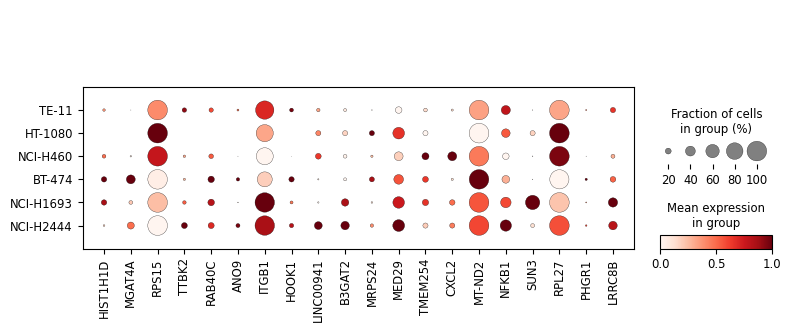

In [22]:
adata_subset = adata[adata.obs.cell_line_name.isin(cell_line_subset.cell_line_name.values)]
sc.pl.dotplot(adata_subset, var_names = coeffcient.genes.values[0:20], 
              groupby = 'cell_line_name', standard_scale='var', 
              categories_order=cell_line_subset.cell_line_name)

We observe that the gene expression pattern is similar within each cell line set but vary across two sets. This implies that genes with high absolute coefficient values have a greater impact on drug response.